# Identifying Generative AI Applications in Smart City Research

In [22]:
# Import Required Libraries
import json
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
from transformers import pipeline
from matplotlib.ticker import MaxNLocator
import torch
from sentence_transformers import SentenceTransformer, util
import spacy

# Set display options
pd.set_option("display.max_colwidth", 100)
sns.set(style="whitegrid")
plt.rcParams.update({"font.size": 12})
plt.rcParams.update({"font.family": "Times New Roman"})

# Set tokenizers parallelism environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Load and Preprocess the data

In [23]:
# Load the abstracts dataset
with open("../data/06_classified_abstracts_smart_domains_mini.json", "r") as f:
    abstracts_data = json.load(f)

print(f"Loaded {len(abstracts_data)} abstract records")

# Create a DataFrame for easier manipulation
df = pd.DataFrame(abstracts_data[:20])

# Display the first few rows to understand the structure
df.head(3)

Loaded 455 abstract records


,abstract,doi,author_keywords,contribution,introduction,classification_result,macro_domains
0,"Building rooftop extraction has been applied in various fields, such as cartography, urban plann...",10.1038/s41598-025-91206-6,"[Building extraction, Multi-scale global perceptron, Remote sensing, Spatial context refinement,...","To address these issues, this study developed a multi-scale global perceptron network based on T...","Building rooftop extraction has been applied in various fields, such as cartography, urban plann...","{'labels': ['Buildings', 'Environment', 'Urban Planning', 'Public Services', 'Industry', 'Housin...","[{'domain': 'Smart Living', 'score': 0.9833354949951172}]"
1,Problem: Modernizing and standardizing place names and addresses is a key challenge in the devel...,10.1016/j.ijcce.2024.12.003,"[Address matching, Attention-based feature interaction method, Directed graph, Interactive addre...","Purpose: This paper proposes a solution to address matching challenges, such as incomplete descr...",Problem: Modernizing and standardizing place names and addresses is a key challenge in the devel...,"{'labels': ['Governance', 'Urban Planning', 'Public Policies', 'Living', 'Citizens', 'Public Ser...","[{'domain': 'Smart Governance', 'score': 0.6886762380599976}]"
2,Distributed multivariate time series anomaly detection is widely-used in industrial equipment mo...,10.1016/j.ipm.2025.104107,"[Distributed anomaly detection, Federated learning, Hypernetworks, Multivariate time series, Ser...","To address these challenges, we propose an Unsupervised Federated Hypernetwork Method for Distri...",Distributed multivariate time series anomaly detection is widely-used in industrial equipment mo...,"{'labels': ['Industry', 'Cybersecurity', 'Business', 'Environment', 'Finance', 'Public Services'...",[]


# Define GenAI Technologies and Keywords

In [24]:
# Define Generative AI technologies and related keywords
# Load from a JSON file
with open("../data/config/genai_technology_domains.json", "r") as f:
    genai_technologies = json.load(f)

# Flatten keywords list for initial screening
all_genai_keywords = []
for tech, keywords in genai_technologies.items():
    all_genai_keywords.extend(keywords)
all_genai_keywords = set(all_genai_keywords)

print(
    f"Using {len(all_genai_keywords)} keywords to identify Generative AI applications"
)

Using 106 keywords to identify Generative AI applications


# Set Up Semantic Matching Environment

In [25]:
# Set device for computation
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Using device: {DEVICE}")

# Load sentence transformer model
print("Loading sentence embedding model...")
sbert_model = SentenceTransformer("paraphrase-MiniLM-L6-v2", device=DEVICE)

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("Loaded spaCy model")
except:
    print("Installing spaCy model...")
    import os

    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")
    print("Loaded spaCy model")

# Pre-compute embeddings for all keywords
print("Computing embeddings for GenAI keywords...")
keyword_list = list(all_genai_keywords)
keyword_embeddings = sbert_model.encode(keyword_list, convert_to_tensor=True)

# Create mappings from technologies to keyword indices
tech_keyword_indices = {}
for tech, tech_keywords in genai_technologies.items():
    tech_keyword_indices[tech] = [
        keyword_list.index(kw) for kw in tech_keywords if kw in keyword_list
    ]

Using device: mps
Loading sentence embedding model...
Loaded spaCy model
Computing embeddings for GenAI keywords...


# Implement Detection Functions

In [26]:
def detect_genai_keywords(text, keywords=all_genai_keywords):
    """
    Detects potential Generative AI applications using basic keyword matching

    Args:
        text (str): Text to analyze
        keywords (set): Set of keywords to search for

    Returns:
        dict: Dictionary with detection results
    """
    if not isinstance(text, str) or not text.strip():
        return {
            "is_genai": False,
            "matched_keywords": [],
            "technology_categories": [],
            "confidence": 0.0,
        }

    # Convert text to lowercase for case-insensitive matching
    text_lower = text.lower()

    # Find all matched keywords
    matched_keywords = [kw for kw in keywords if kw in text_lower]

    # Identify which technology categories are mentioned
    tech_categories = []
    for tech, tech_keywords in genai_technologies.items():
        if any(kw in text_lower for kw in tech_keywords):
            tech_categories.append(tech)

    # Calculate confidence based on number and diversity of matches
    base_confidence = min(len(matched_keywords) * 0.2, 0.6)
    category_bonus = min(len(tech_categories) * 0.2, 0.4)
    confidence = base_confidence + category_bonus

    # Determine if it's a GenAI application
    is_genai = confidence >= 0.45

    return {
        "is_genai": is_genai,
        "matched_keywords": matched_keywords,
        "technology_categories": tech_categories,
        "confidence": confidence,
    }


def detect_genai_semantic(text, similarity_threshold=0.65):
    """
    Enhanced detection using semantic similarity to find GenAI applications

    Args:
        text (str): Text to analyze
        similarity_threshold (float): Threshold for semantic similarity

    Returns:
        dict: Enhanced detection results including semantic matches
    """
    if not isinstance(text, str) or not text.strip():
        return {
            "is_genai": False,
            "matched_keywords": [],
            "technology_categories": [],
            "confidence": 0.0,
            "semantic_matches": [],
            "bridge_terms": [],
        }

    # Convert to lowercase for case-insensitive matching
    text_lower = text.lower()

    # 1. EXACT MATCHING: Check for exact keyword matches
    exact_matches = [kw for kw in keyword_list if kw in text_lower]

    # 2. WORD BOUNDARY MATCHING: Check for whole word matches
    word_boundary_matches = []
    text_tokens = set(re.findall(r"\b\w+\b", text_lower))
    for kw in keyword_list:
        kw_tokens = set(re.findall(r"\b\w+\b", kw.lower()))
        if kw_tokens and kw_tokens.issubset(text_tokens):
            word_boundary_matches.append(kw)

    # 3. SEMANTIC MATCHING: Use embeddings to find semantic matches
    semantic_matches = []
    try:
        # Encode the text
        text_embedding = sbert_model.encode(text, convert_to_tensor=True)

        # Calculate similarity with all keywords
        similarities = util.pytorch_cos_sim(text_embedding, keyword_embeddings)[0]

        # Find the most similar keywords
        best_matches = torch.topk(similarities, k=min(5, len(similarities)))

        for score_idx, keyword_idx in enumerate(best_matches.indices):
            score = best_matches.values[score_idx].item()
            if score >= similarity_threshold:
                keyword = keyword_list[keyword_idx]
                semantic_matches.append((keyword, score))
    except Exception as e:
        print(f"Error in semantic matching: {e}")

    # Combine all matches
    all_matched_keywords = list(
        set(exact_matches + word_boundary_matches + [m[0] for m in semantic_matches])
    )

    # Identify technology categories
    tech_categories = []
    for tech, tech_keywords in genai_technologies.items():
        if any(kw in all_matched_keywords for kw in tech_keywords):
            tech_categories.append(tech)

    # Calculate confidence score (enhanced with semantic info)
    exact_confidence = min(len(exact_matches) * 0.2, 0.5)
    boundary_confidence = min(len(word_boundary_matches) * 0.15, 0.3)
    semantic_confidence = min(sum(score for _, score in semantic_matches) * 0.2, 0.4)
    category_confidence = min(len(tech_categories) * 0.15, 0.3)

    overall_confidence = (
        exact_confidence
        + boundary_confidence
        + semantic_confidence
        + category_confidence
    )
    overall_confidence = min(overall_confidence, 1.0)  # Cap at 1.0

    # Extract bridge terms (connecting terms)
    bridge_terms = []
    try:
        doc = nlp(text)
        potential_bridges = [
            token.lemma_.lower()
            for token in doc
            if token.pos_ in ["NOUN", "VERB", "ADJ"]
            and token.is_alpha
            and len(token.text) > 2
            and not any(kw.lower() in token.text.lower() for kw in all_genai_keywords)
        ]

        # Count occurrences
        bridge_counts = Counter(potential_bridges)
        bridge_terms = bridge_counts.most_common(5)
    except Exception as e:
        print(f"Error extracting bridge terms: {e}")

    # Determine if it's a GenAI application
    is_genai = overall_confidence >= 0.5

    return {
        "is_genai": is_genai,
        "matched_keywords": all_matched_keywords,
        "technology_categories": tech_categories,
        "confidence": overall_confidence,
        "semantic_matches": semantic_matches,
        "bridge_terms": bridge_terms,
    }


def classify_genai_application(text):
    """
    Uses zero-shot classification to determine if text describes a GenAI application

    Args:
        text (str): Text to classify

    Returns:
        dict: Classification results
    """
    if not isinstance(text, str) or not text.strip():
        return {"is_genai_application": False, "score": 0.0}

    # Define classes for classification
    classes = [
        "mentions a Generative AI application in smart cities",
        "mentions Generative AI model but not as an application",
        "mentions AI but not generative models",
        "does not discuss AI technologies",
    ]

    try:
        # Perform classification
        result = classifier(
            text,
            candidate_labels=classes,
            hypothesis_template="This text {}.",
            multi_label=False,
        )

        # Extract the top prediction and score
        top_label = result["labels"][0]
        top_score = result["scores"][0]

        # Determine if it's a GenAI application
        is_genai_application = top_label == classes[0]

        return {
            "is_genai_application": is_genai_application,
            "top_label": top_label,
            "score": top_score,
            "all_labels": result["labels"],
            "all_scores": result["scores"],
        }
    except Exception as e:
        print(f"Error in classification: {e}")
        return {"is_genai_application": False, "score": 0.0}

# Initialize Zero-Shot Classifier

In [27]:
# Initialize zero-shot classifier
print("Initializing zero-shot classifier...")
classifier = pipeline(
    "zero-shot-classification",
    model="MoritzLaurer/deberta-v3-large-zeroshot-v2.0-c",
    device=DEVICE,
)
print("Zero-shot classifier initialized")

Initializing zero-shot classifier...


Device set to use mps


Zero-shot classifier initialized


# Apply Analysis to Abstracts

In [29]:
# Apply all detection methods
tqdm.pandas(desc="Applying keyword detection")
df["genai_detection"] = df.apply(
    lambda row: detect_genai_keywords(
        # Concatenate contribution with author keywords if available
        str(row["contribution"]) + " " + " ".join(row["author_keywords"] if isinstance(row["author_keywords"], list) else [])
    ),
    axis=1
)

# Extract basic keyword results
df["has_genai_keywords"] = df["genai_detection"].apply(lambda x: x["is_genai"])
df["genai_keywords"] = df["genai_detection"].apply(lambda x: x["matched_keywords"])
df["genai_categories"] = df["genai_detection"].apply(
    lambda x: x["technology_categories"]
)
df["genai_keyword_confidence"] = df["genai_detection"].apply(lambda x: x["confidence"])

# Apply semantic detection
tqdm.pandas(desc="Applying semantic detection")
df["semantic_detection"] = df["contribution"].progress_apply(detect_genai_semantic)

# Extract semantic results
df["semantic_is_genai"] = df["semantic_detection"].apply(lambda x: x["is_genai"])
df["semantic_confidence"] = df["semantic_detection"].apply(lambda x: x["confidence"])
df["semantic_keywords"] = df["semantic_detection"].apply(
    lambda x: x["matched_keywords"]
)
df["semantic_categories"] = df["semantic_detection"].apply(
    lambda x: x["technology_categories"]
)
df["bridge_terms"] = df["semantic_detection"].apply(lambda x: x["bridge_terms"])
df["semantic_matches"] = df["semantic_detection"].apply(lambda x: x["semantic_matches"])

# Apply zero-shot classification
tqdm.pandas(desc="Applying zero-shot classification")
df["genai_classification"] = df["contribution"].progress_apply(
    classify_genai_application
)
df["is_genai_application"] = df["genai_classification"].apply(
    lambda x: x["is_genai_application"]
)
df["classification_score"] = df["genai_classification"].apply(
    lambda x: x.get("score", 0)
)

# Summary statistics
print(
    f"\nAbstracts with GenAI keywords: {df['has_genai_keywords'].sum()} ({df['has_genai_keywords'].mean()*100:.2f}%)"
)
print(
    f"Abstracts with semantic GenAI detection: {df['semantic_is_genai'].sum()} ({df['semantic_is_genai'].mean()*100:.2f}%)"
)
print(
    f"Abstracts classified as GenAI applications: {df['is_genai_application'].sum()} ({df['is_genai_application'].mean()*100:.2f}%)"
)

Applying semantic detection:   0%|          | 0/20 [00:00<?, ?it/s]

Applying zero-shot classification:   0%|          | 0/20 [00:00<?, ?it/s]


Abstracts with GenAI keywords: 13 (65.00%)
Abstracts with semantic GenAI detection: 16 (80.00%)
Abstracts classified as GenAI applications: 4 (20.00%)


# Create Combined Detection Metrics

In [30]:
# Combine methods
print("\nCombining detection methods...")

# Combined detection (using information from all methods)
df["final_is_genai"] = df.apply(
    lambda row: (
        row["has_genai_keywords"]  # Basic keyword detection
        or (
            row["semantic_is_genai"] and row["semantic_confidence"] > 0.65
        )  # Semantic detection
        or (
            row["is_genai_application"] and row["classification_score"] > 0.6
        )  # Zero-shot classification
    ),
    axis=1,
)

# Calculate weighted confidence score
df["final_confidence"] = df.apply(
    lambda row: (
        (
            (row["genai_keyword_confidence"] * 0.3)  # Basic keyword weight
            + (row["semantic_confidence"] * 0.4)  # Semantic weight
            + (row["classification_score"] * 0.3)  # Zero-shot weight
        )
        if row["final_is_genai"]
        else 0.0
    ),
    axis=1,
)

# Determine primary detection method
df["primary_detection_method"] = df.apply(
    lambda row: (
        "Keyword"
        if (
            row["has_genai_keywords"]
            and not row["semantic_is_genai"]
            and not row["is_genai_application"]
        )
        else (
            "Semantic"
            if (
                row["semantic_is_genai"]
                and not row["has_genai_keywords"]
                and not row["is_genai_application"]
            )
            else (
                "Zero-Shot"
                if (
                    row["is_genai_application"]
                    and not row["has_genai_keywords"]
                    and not row["semantic_is_genai"]
                )
                else "Multiple" if row["final_is_genai"] else "None"
            )
        )
    ),
    axis=1,
)

# Summary statistics with all methods
print("\nDetection Method Comparison:")
print(
    f"Basic keyword detection: {df['has_genai_keywords'].sum()} articles ({df['has_genai_keywords'].mean()*100:.2f}%)"
)
print(
    f"Semantic detection: {df['semantic_is_genai'].sum()} articles ({df['semantic_is_genai'].mean()*100:.2f}%)"
)
print(
    f"Zero-shot classification: {df['is_genai_application'].sum()} articles ({df['is_genai_application'].mean()*100:.2f}%)"
)
print(
    f"Combined detection: {df['final_is_genai'].sum()} articles ({df['final_is_genai'].mean()*100:.2f}%)"
)


Combining detection methods...

Detection Method Comparison:
Basic keyword detection: 13 articles (65.00%)
Semantic detection: 16 articles (80.00%)
Zero-shot classification: 4 articles (20.00%)
Combined detection: 14 articles (70.00%)


In [31]:
df

,abstract,doi,author_keywords,contribution,introduction,classification_result,macro_domains,genai_detection,has_genai_keywords,genai_keywords,...,semantic_keywords,semantic_categories,bridge_terms,semantic_matches,genai_classification,is_genai_application,classification_score,final_is_genai,final_confidence,primary_detection_method
0,"Building rooftop extraction has been applied in various fields, such as cartography, urban plann...",10.1038/s41598-025-91206-6,"[Building extraction, Multi-scale global perceptron, Remote sensing, Spatial context refinement,...","To address these issues, this study developed a multi-scale global perceptron network based on T...","Building rooftop extraction has been applied in various fields, such as cartography, urban plann...","{'labels': ['Buildings', 'Environment', 'Urban Planning', 'Public Services', 'Industry', 'Housin...","[{'domain': 'Smart Living', 'score': 0.9833354949951172}]","{'is_genai': True, 'matched_keywords': ['transformer', 'encoder-decoder'], 'technology_categorie...",True,"[transformer, encoder-decoder]",...,"[transformer, score-based model, encoder-decoder]","[Transformer-Based Models, Diffusion Models]","[(multi, 3), (develop, 2), (scale, 2), (global, 2), (use, 2)]",[],"{'is_genai_application': False, 'top_label': 'mentions Generative AI model but not as an applica...",False,0.476650,True,0.722995,Multiple
1,Problem: Modernizing and standardizing place names and addresses is a key challenge in the devel...,10.1016/j.ijcce.2024.12.003,"[Address matching, Attention-based feature interaction method, Directed graph, Interactive addre...","Purpose: This paper proposes a solution to address matching challenges, such as incomplete descr...",Problem: Modernizing and standardizing place names and addresses is a key challenge in the devel...,"{'labels': ['Governance', 'Urban Planning', 'Public Policies', 'Living', 'Citizens', 'Public Ser...","[{'domain': 'Smart Governance', 'score': 0.6886762380599976}]","{'is_genai': True, 'matched_keywords': ['attention mechanism', 'large language model', 'llm'], '...",True,"[attention mechanism, large language model, llm]",...,"[large language model, llm, score-based model, attention mechanism]","[Transformer-Based Models, Diffusion Models]","[(address, 8), (model, 5), (method, 4), (matching, 3), (chinese, 3)]",[],"{'is_genai_application': False, 'top_label': 'mentions AI but not generative models', 'score': 0...",False,0.474479,True,0.782344,Multiple
2,Distributed multivariate time series anomaly detection is widely-used in industrial equipment mo...,10.1016/j.ipm.2025.104107,"[Distributed anomaly detection, Federated learning, Hypernetworks, Multivariate time series, Ser...","To address these challenges, we propose an Unsupervised Federated Hypernetwork Method for Distri...",Distributed multivariate time series anomaly detection is widely-used in industrial equipment mo...,"{'labels': ['Industry', 'Cybersecurity', 'Business', 'Environment', 'Finance', 'Public Services'...",[],"{'is_genai': False, 'matched_keywords': ['transformer'], 'technology_categories': ['Transformer-...",False,[transformer],...,[transformer],[Transformer-Based Models],"[(ufedhy, 5), (average, 3), (subsequence, 2), (dismtsadd, 2), (score, 2)]",[],"{'is_genai_application': False, 'top_label': 'mentions AI but not generative models', 'score': 0...",False,0.744442,False,0.000000,Semantic
3,The integration of renewable energy into power networks introduces challenges due to intermitten...,10.1016/j.apenergy.2025.125531,"[Conditional value-at-risk, Optimal planning, Remuneration, Renewable generation, Seasonal impac...",This research introduces a novel two-stage stochastic approach for distribution network expansio...,The integration of renewable energy into power networks introduces challenges due to intermitten...,"{'labels': ['Renewable Energy', 'Sustainability', 'Energy Management', 'Power Distribution', 'En...","[{'domain': 'Smart Environment', 'score': 0.9989933967590332}]

In [32]:
# Save a csv file with the contribution, genai detection has keywords, semantic genai and confidence, genai classification
# Prepare dataframe with selected columns for export
export_df = df[
    [
        "is_genai_application",
        "final_is_genai",
        "doi",
        "contribution",
        "has_genai_keywords",
        "semantic_is_genai",
        "semantic_confidence",
        "classification_score",
        "final_confidence",
        "primary_detection_method",
    ]
]

# Add year if available
if 'year' in df.columns:
    export_df = df[
        [
            "is_genai_application",
            "final_is_genai",
            "doi",
            "year",
            "contribution",
            "has_genai_keywords",
            "semantic_is_genai",
            "semantic_confidence",
            "classification_score",
            "final_confidence",
            "primary_detection_method",
        ]
    ]

# Create output directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# Save to CSV
export_path = '../data/processed/genai_detection_results.csv'
export_df.to_csv(export_path, index=False)
print(f"Results saved to {export_path}")

Results saved to ../data/processed/genai_detection_results.csv


# Analyze GenAI Applications in Detail

In [64]:
# Filter to only GenAI applications (using combined approach)
genai_df = df[df["final_is_genai"]]

# Find articles identified by semantic matching but not by keywords
semantic_only = df[(~df["has_genai_keywords"]) & (df["semantic_is_genai"])].copy()
print(f"\nArticles detected through semantic analysis only: {len(semantic_only)}")

if len(semantic_only) > 0:
    # Print example of semantic detection
    example = semantic_only.iloc[0]
    print("\nExample of semantic-only detection:")
    print(f"DOI: {example['doi']}")
    print(f"Semantic matches: {example['semantic_matches']}")
    print(f"Bridge terms: {example['bridge_terms']}")
    print(f"Abstract (excerpt): {example['abstract'][:200]}...")

# Show most common GenAI keywords
all_keywords = []
for sublist in genai_df["genai_keywords"].tolist():
    if isinstance(sublist, list):
        all_keywords.extend(sublist)
keyword_counts = Counter(all_keywords)

print("\nMost common GenAI keywords in confirmed applications:")
for keyword, count in keyword_counts.most_common(10):
    print(f"- {keyword}: {count}")

# Show distribution of GenAI technology categories
all_categories = []
for sublist in genai_df["genai_categories"].tolist():
    if isinstance(sublist, list):
        all_categories.extend(sublist)
category_counts = Counter(all_categories)

print("\nDistribution of GenAI technology categories:")
for category, count in category_counts.most_common():
    print(f"- {category}: {count}")

# Analyze bridge terms
all_bridges = []
for bridges in df[df["final_is_genai"]]["bridge_terms"]:
    if isinstance(bridges, list):
        all_bridges.extend([term for term, count in bridges])

bridge_counts = Counter(all_bridges)
print("\nTop connecting terms between GenAI and Smart Cities:")
for term, count in bridge_counts.most_common(10):
    print(f"- {term}: {count}")

# Analyze smart city domains where GenAI is being applied
if "macro_domains" in genai_df.columns:
    # Extract domain names from macro_domains lists
    genai_domains = []
    for domains in genai_df["macro_domains"]:
        if domains and isinstance(domains, list):
            for domain in domains:
                if isinstance(domain, dict) and "domain" in domain:
                    genai_domains.append(domain["domain"])

    domain_counts = Counter(genai_domains)

    print("\nSmart city domains where GenAI is being applied:")
    for domain, count in domain_counts.most_common():
        print(f"- {domain}: {count}")


Articles detected through semantic analysis only: 5

Example of semantic-only detection:
DOI: 10.1016/j.ipm.2025.104107
Semantic matches: []
Bridge terms: [('ufedhy', 5), ('average', 3), ('subsequence', 2), ('dismtsadd', 2), ('score', 2)]
Abstract (excerpt): Distributed multivariate time series anomaly detection is widely-used in industrial equipment monitoring, financial risk management, and smart cities. Although Federated learning (FL) has garnered sig...

Most common GenAI keywords in confirmed applications:
- transformer: 5
- attention mechanism: 4
- large language model: 3
- llm: 3
- gan: 3
- generative adversarial network: 3
- encoder-decoder: 1
- autoencoder: 1
- cgan: 1
- foundational framework: 1

Distribution of GenAI technology categories:
- Transformer-Based Models: 9
- Generative Adversarial Networks: 3
- Variational Autoencoders: 1

Top connecting terms between GenAI and Smart Cities:
- use: 4
- propose: 3
- datum: 3
- multi: 2
- model: 2
- traffic: 2
- temporal: 2
- fe

# Visualize the Results

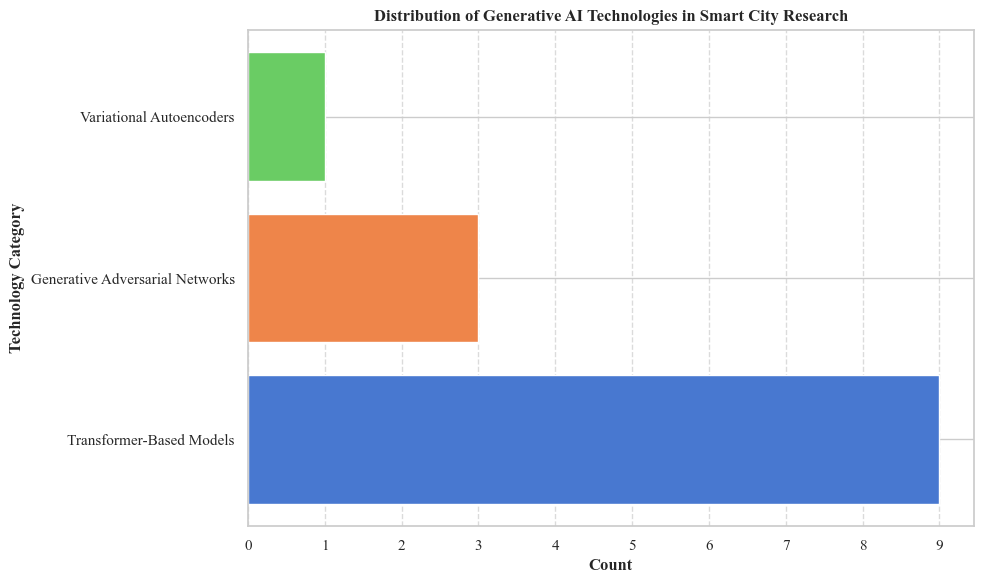

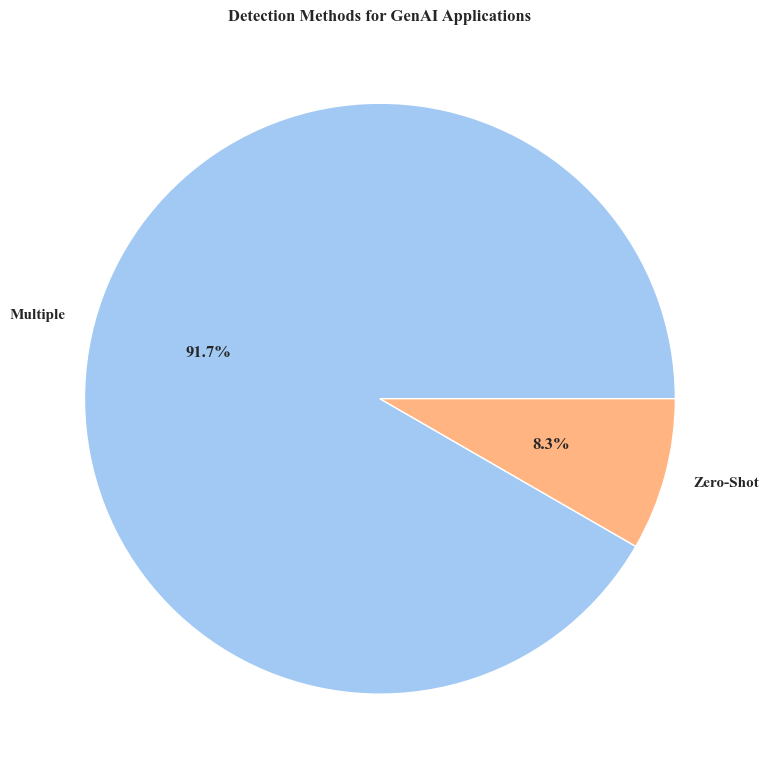

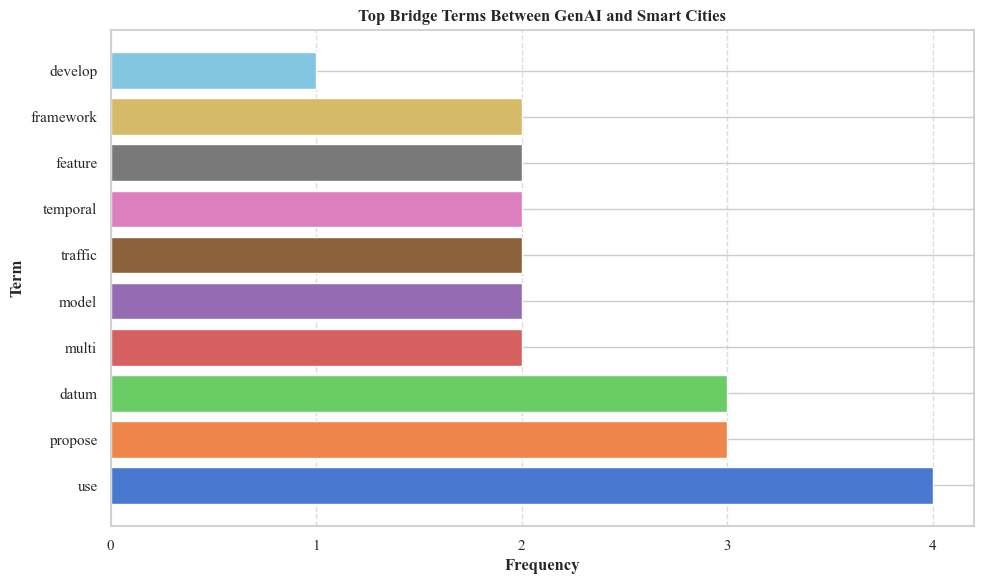

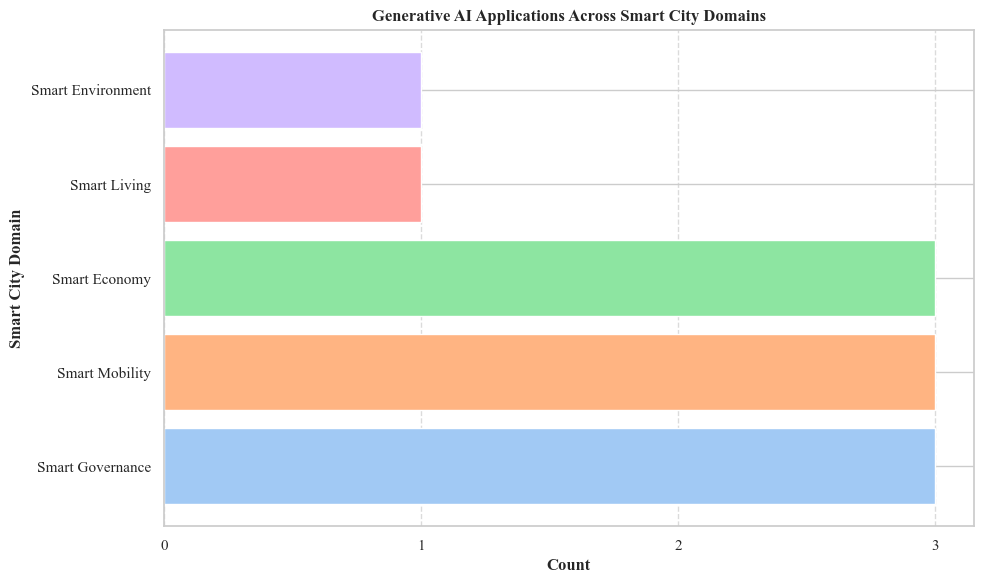

In [65]:
# Plot distribution of GenAI categories with integer counts
plt.figure(figsize=(10, 6))
categories = [cat for cat, _ in category_counts.most_common()]
counts = [count for _, count in category_counts.most_common()]

# Create a matte color palette
matte_palette = sns.color_palette("muted", len(categories))

# Use matplotlib with matte colors
plt.barh(y=range(len(categories)), width=counts, color=matte_palette)
plt.yticks(range(len(categories)), categories)

# Format x-axis with integer values only
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Add grid lines for better readability
plt.grid(axis="x", linestyle="--", alpha=0.7)

plt.title(
    "Distribution of Generative AI Technologies in Smart City Research",
    fontweight="bold",
)
plt.xlabel("Count", fontweight="bold")
plt.ylabel("Technology Category", fontweight="bold")
plt.tight_layout()
plt.show()

# Plot detection methods
detection_counts = df[df["final_is_genai"]]["primary_detection_method"].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(
    detection_counts,
    labels=detection_counts.index,
    autopct="%1.1f%%",
    colors=sns.color_palette("pastel", len(detection_counts)),
    textprops={"fontweight": "bold"},
)
plt.title("Detection Methods for GenAI Applications", fontweight="bold")
plt.tight_layout()
plt.show()

# Plot bridge terms
if bridge_counts:
    top_bridges = bridge_counts.most_common(10)
    plt.figure(figsize=(10, 6))

    # Use matte colors
    bridge_palette = sns.color_palette("muted", len(top_bridges))

    plt.barh(
        y=range(len(top_bridges)),
        width=[count for _, count in top_bridges],
        color=bridge_palette,
    )
    plt.yticks(range(len(top_bridges)), [term for term, _ in top_bridges])
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    plt.title("Top Bridge Terms Between GenAI and Smart Cities", fontweight="bold")
    plt.xlabel("Frequency", fontweight="bold")
    plt.ylabel("Term", fontweight="bold")
    plt.tight_layout()
    plt.show()

# Plot smart city domains if data available
if "macro_domains" in genai_df.columns and len(domain_counts) > 0:
    plt.figure(figsize=(10, 6))
    domains = [domain for domain, _ in domain_counts.most_common()]
    counts = [count for _, count in domain_counts.most_common()]

    # Use matte colors from a different palette for variety
    matte_domain_palette = sns.color_palette("pastel", len(domains))

    plt.barh(y=range(len(domains)), width=counts, color=matte_domain_palette)
    plt.yticks(range(len(domains)), domains)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    plt.title("Generative AI Applications Across Smart City Domains", fontweight="bold")
    plt.xlabel("Count", fontweight="bold")
    plt.ylabel("Smart City Domain", fontweight="bold")
    plt.tight_layout()
    plt.show()

In [66]:
# Display some example GenAI applications with high confidence
print("\nExamples of Generative AI applications in Smart Cities:")
for i, (_, row) in enumerate(
    genai_df.sort_values("classification_score", ascending=False).head(5).iterrows()
):
    print(f"\n{i+1}. {row['doi']} (Confidence: {row['classification_score']:.2f})")
    print(f"GenAI technologies: {', '.join(row['genai_categories'])}")
    print(f"Keywords: {', '.join(row['genai_keywords'])}")
    print(f"Abstract preview: {row['abstract'][:300]}...")
    print(f"Contribution: {row['contribution'][:800]}...")


Examples of Generative AI applications in Smart Cities:

1. 10.1002/dac.70035 (Confidence: 0.85)
GenAI technologies: Transformer-Based Models, Variational Autoencoders
Keywords: attention mechanism, transformer, autoencoder
Abstract preview: The efficient management and prediction of urban traffic flow are paramount in the age of beyond 5G smart cities and advanced transportation systems. Traditional methods often fail to handle the nonlinear and dynamic nature of traffic data, necessitating more advanced solutions. This paper introduce...
Contribution: This paper introduces NeuroSync, a novel neural network architecture designed to leverage the strengths of spiking neuron layers and gated recurrent units (GRUs) combined with temporal pattern attention mechanisms to effectively forecast traffic patterns. The architecture is specifically tailored to address the complexities inherent in nonstationary urban traffic datasets, capturing both spatial and temporal relationships within the da